
Classifier                                    Dataset                                  TP      FP      TN      FN
HardwareClassifier                            final_all_triggers                    89144       0       0  156908 -> ACC =  36.23%


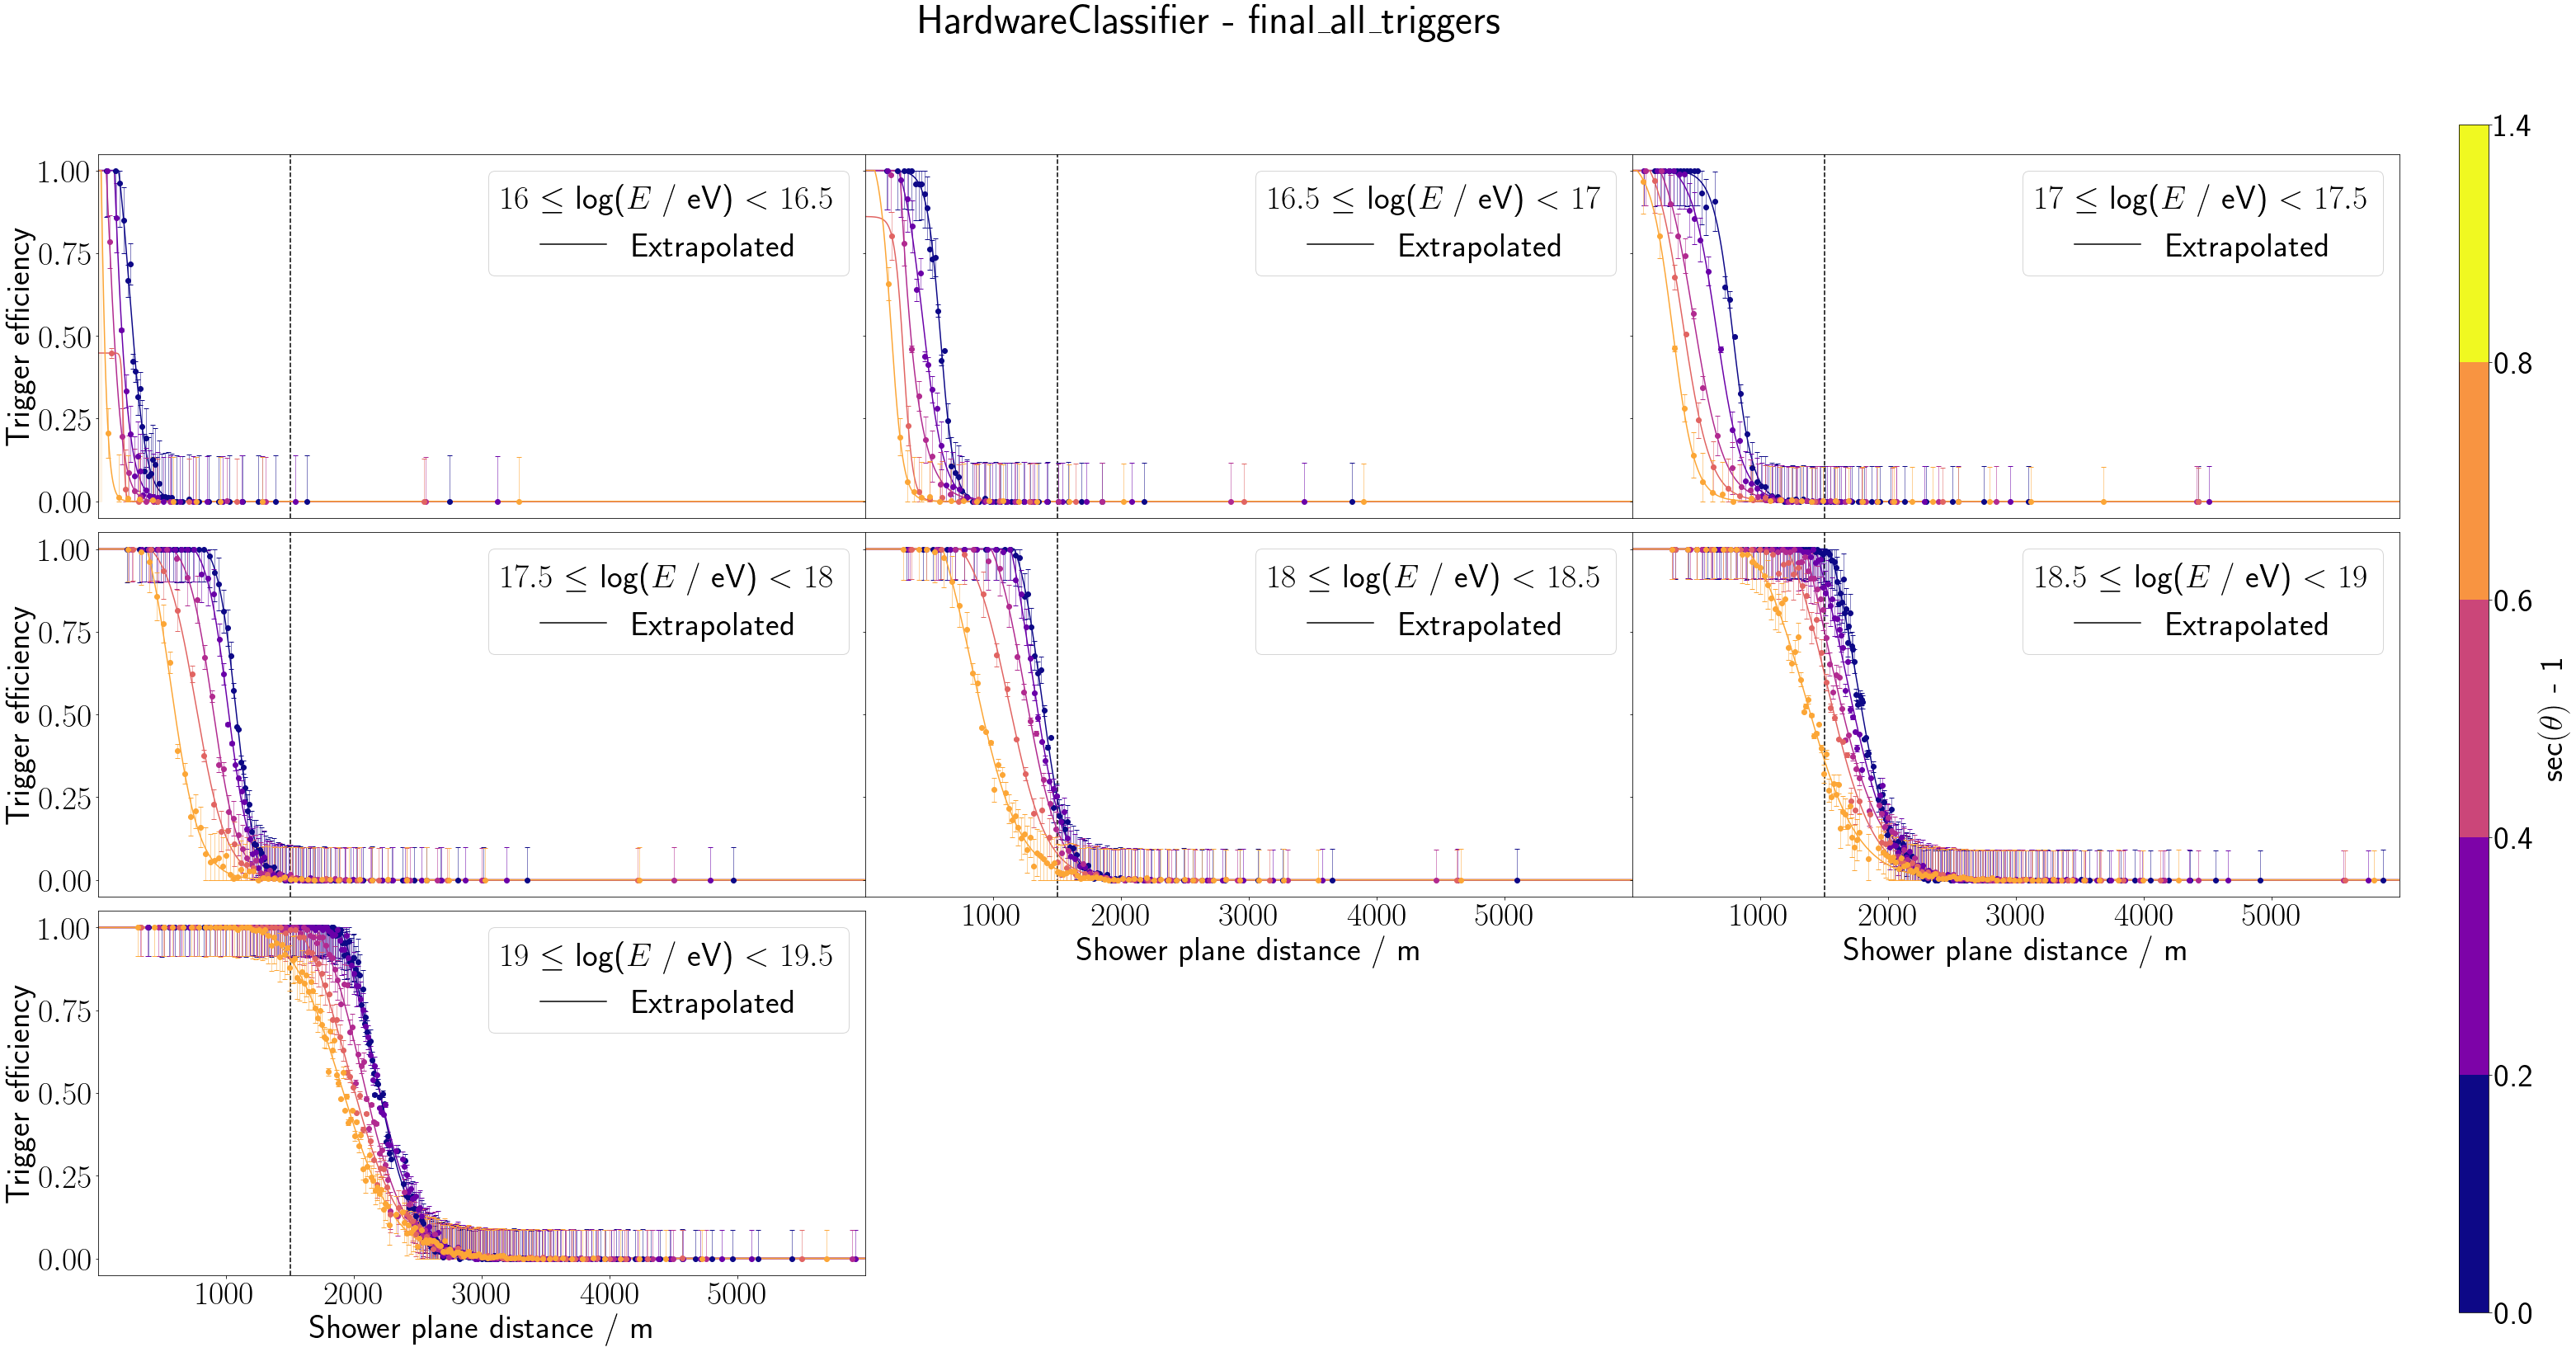

In [2]:
from Binaries import *

Trigger = HardwareClassifier()

Trigger.spd_energy_efficiency("final_all_triggers")

In [3]:
def show_bias(dataset):

    fig, axes = plt.subplots(nrows = 1)

    Trigger = HardwareClassifier()
    TP, FP, TN, FN = Trigger.load_and_print_performance(dataset)

    c = lambda x, i : x.split("_")[i]
    root_path = "/cr/tempdata01/filip/QGSJET-II/LTP/BINNED/"
    checksum = lambda x : sum([10*float(c(x,0)), 10*float(c(x,1)), float(c(x,3))/10, float(c(x,4)[:-4])/10])
    ldf_files = np.array(os.listdir(root_path))[np.argsort([checksum(file) for file in os.listdir(root_path )])]
    ldf_files = [root_path + ldf_file for ldf_file in ldf_files]

    warnings.simplefilter("ignore", RuntimeWarning)
    colormap = cmap.get_cmap("plasma")
    bar_kwargs = \
    {
        "elinewidth" : 0.5,
        "capsize" : 3
    }

    y_vals = []

    markersize = [4, 5, 6, 7, 8, 9, 10, 11]

    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
    annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

    energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
    hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

    # Sort predictions into bins of theta and energy
    for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

        spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
        energy_sorted = np.digitize(energy, energy_bins)
        theta_sorted = np.digitize(theta, theta_bins)

        for e, t, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
            target[e - 1][t - 1].append(shower_plane_distance)

    # Calculate efficiencies given sorted performances
    # axis 1 = sorted by primary particles' energy
    for e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

        ax = axes
        ax.axhline(0, c = "k", ls = "--")
        ax.set_xlim(-1750, 1750)
        marker = "x" if e < 2 else "o"
        size = markersize[e]

        # axis 2 = sorted by zenith angle
        for t, (hits, misses) in enumerate(zip(hits, misses)):

            c = colormap(t / (len(theta_bins) - 1))

            spd, x, o = np.loadtxt(ldf_files[e * 5 + t], unpack = True, usecols = [0, 1, 2])
            LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", e, t)
            LDF = lambda x : lateral_distribution_function(x, LDF_efficiency, LDF_prob_50, 1/LDF_scale)
            LTP, (LTP_efficiency, LTP_prob_50, LTP_scale) = get_fit_function(f"/cr/data01/filip/models/HardwareClassifier/ROC_curve/{dataset}/", e, t)

            if LTP_efficiency <= 1: continue

            offset = LTP_prob_50 - np.log(1/(1-1/LTP_efficiency)-1)/LTP_scale

            all_data = hits + misses
            n_data_in_bins = 500

            # have at least 7 bins or bins with >50 samples
            while True:
                n_bins = len(all_data) // n_data_in_bins
                probabilities = np.linspace(0, 1, n_bins)
                binning = mquantiles(all_data, prob = probabilities)
                bin_center = 0.5 * (binning[1:] + binning[:-1])
                n_all, _ = np.histogram(all_data, bins = binning)

                if len(n_all) <= 7: 
                    n_data_in_bins -= 10
                    if n_data_in_bins == 50: break
                else: break

            x, _ = np.histogram(hits, bins = binning)
            o, _ = np.histogram(misses, bins = binning)
            efficiency = x / (x + o) * LDF(bin_center)
            efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
            efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

            y_vals.append(efficiency - LTP(bin_center))
            ax.errorbar(bin_center - offset, efficiency - LTP(bin_center), yerr = efficiency_err *0.2, color = c, **bar_kwargs, fmt = marker, markersize = size)

    norm = BoundaryNorm(theta_bins, colormap.N)
    ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks(theta_bins)
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    plt.subplots_adjust(hspace = 0.0, wspace = 0)

    ax.set_xlabel("Distance from full efficiency transition$\,/\,\mathrm{m}$")
    ax.set_ylabel("$\epsilon^\mathrm{True}(r) - \mathrm{LTP}^*(r)$")

    warnings.simplefilter("default", RuntimeWarning)

    return y_vals

HardwareClassifier                            final_all_triggers                    89144       0       0  156908 -> ACC =  36.23%


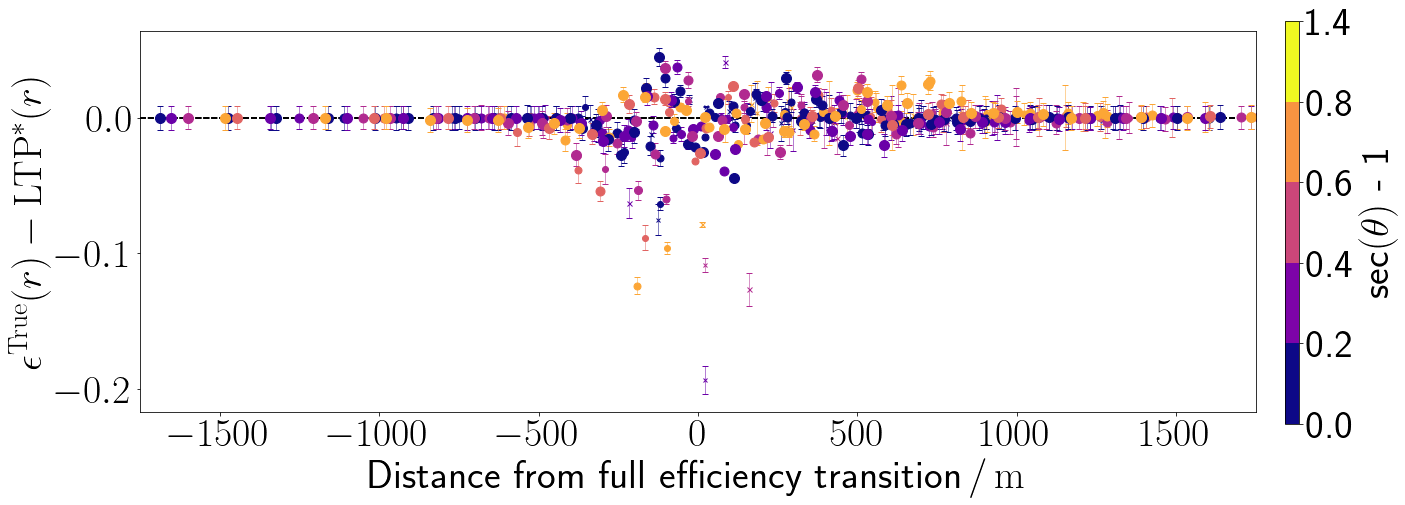

In [4]:
plt.rcParams["figure.figsize"] = [20, 7]
y = show_bias("final_all_triggers")

-0.0024777944183178155
0.018311060617888324


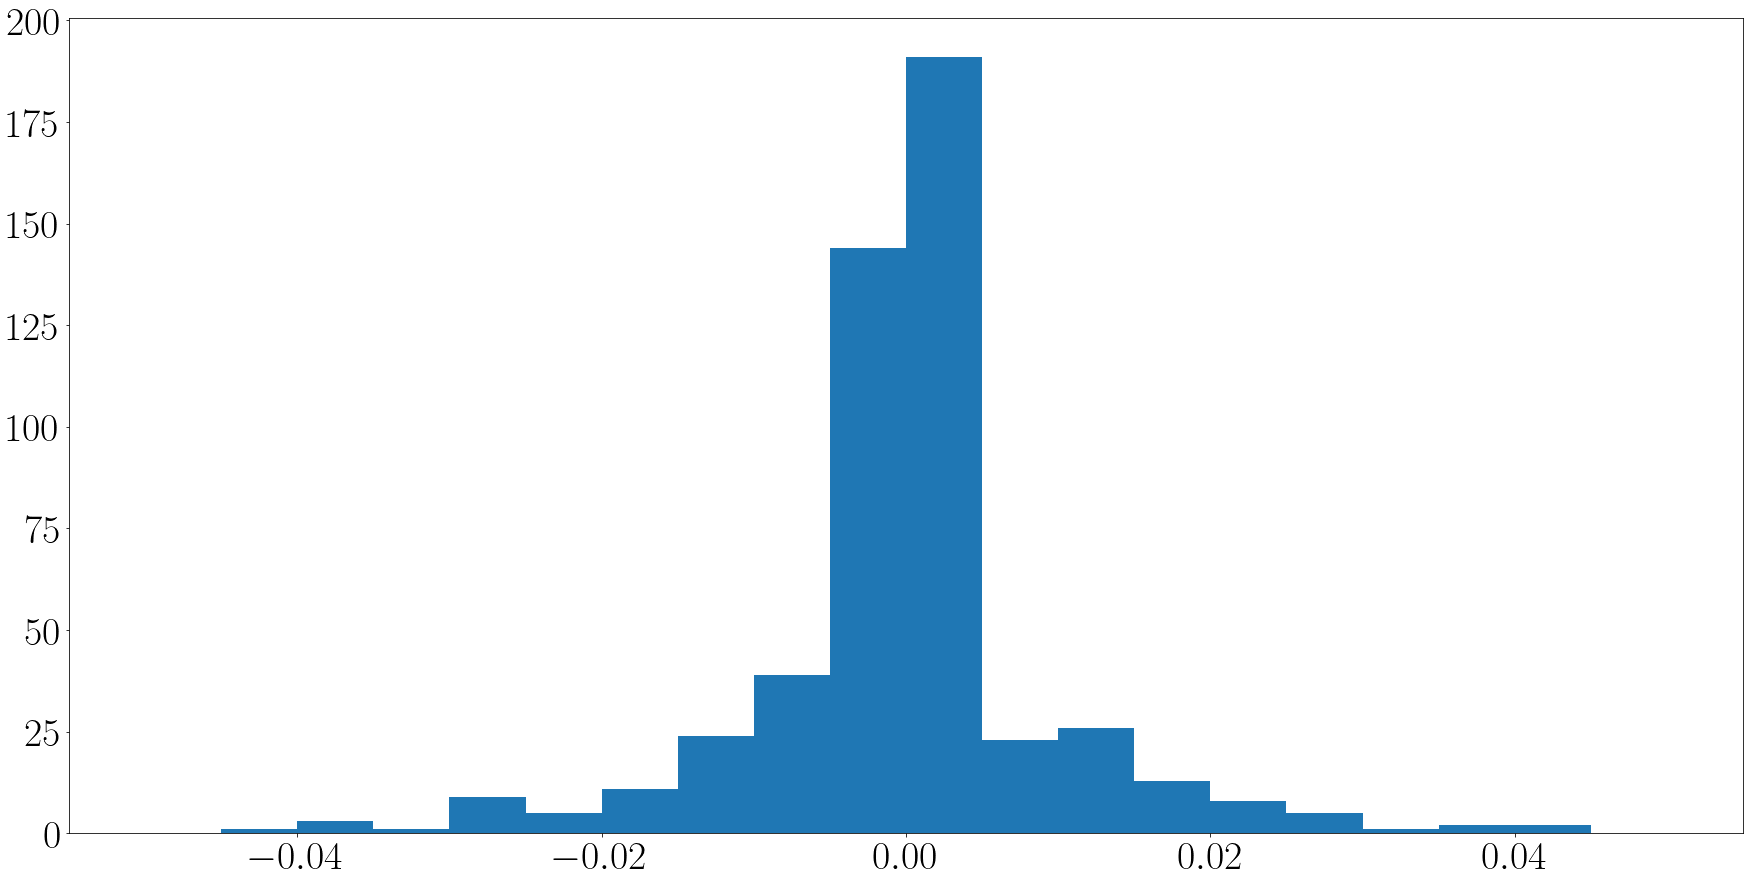

In [7]:
y = [item for sublist in y for item in sublist]

plt.rcParams["figure.figsize"] = [30, 15]
_ = plt.hist(y, range = (-0.05, 0.05), bins = 20)

print(np.mean(y))
print(np.std(y))